In [ ]:
import pandas as pd
import numpy as np

import warnings
import math

from scipy.spatial.distance import pdist, squareform

from datetime import datetime

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from phik.report import plot_correlation_matrix
from phik import report

from sklearn.metrics import log_loss, classification_report, auc, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier

# import uuid
import missingno as msno

import hashlib

import os

import lightgbm as lgb
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

# Loading dataset

In [ ]:
data = pd.read_csv('doors_data.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3213 entries, 0 to 3212
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      3213 non-null   int64  
 1   floor           3213 non-null   object 
 2   door_type       3204 non-null   object 
 3   door_number     3211 non-null   object 
 4   door_leaf       3213 non-null   object 
 5   width           3213 non-null   float64
 6   height          3213 non-null   float64
 7   r_l_opening     3213 non-null   object 
 8   is_escape       3213 non-null   object 
 9   host_width      3213 non-null   float64
 10  host_material   3213 non-null   object 
 11  from_room       3213 non-null   object 
 12  to_room         3213 non-null   object 
 13  from_room_area  3213 non-null   float64
 14  to_room_area    3213 non-null   float64
 15  frame_type      3196 non-null   object 
 16  frame_material  3213 non-null   object 
 17  frame_finish    3199 non-null   o

# Features for training

In [ ]:
feature_columns = [
    'floor',
    'door_leaf',
    'width',
    'height',
    'r_l_opening',
    'host_width',
    'host_material',
    'from_room',
    'to_room',
    'from_room_area',
    'to_room_area',
]

In [ ]:
X = data[feature_columns].columns
y = ['frame_material']

# Categorical data

In [ ]:
categorical = [
    'floor',
    'door_leaf',
    'r_l_opening',
    'host_material',
    'from_room',
    'to_room'
]

# Picking office buildings out of df

In [ ]:
data['project'].value_counts()

maf     889
giz     770
tam5    554
hfmt    323
sph     299
ahq     257
kap     121
Name: project, dtype: int64

# Train - hfmt, giz, sph, ahq

In [ ]:
office_train = data[(data['project']=='hfmt') |
             (data['project']=='giz') |
             (data['project']=='sph') |
             (data['project']=='ahq')]

### Projects distribution

In [ ]:
office_train['project'].value_counts()

giz     770
hfmt    323
sph     299
ahq     257
Name: project, dtype: int64

### Train - target data balance

In [ ]:
office_train['frame_material'].value_counts()

S     1189
A      366
H       49
gD      45
Name: frame_material, dtype: int64

### Train, val

In [ ]:
train, val = train_test_split(office_train,
                            train_size=0.8,
                            random_state=42,
                            stratify=office_train['frame_material'])
print(val.shape)
print(train.shape)

(330, 19)
(1319, 19)


In [ ]:
# train.info()

# Test - tam5

In [ ]:
test = data[data['project']=='tam5']

### Test - target data balance

In [ ]:
test['frame_material'].value_counts()

S    458
A     96
Name: frame_material, dtype: int64

# Train-Test check

In [ ]:
train[X].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1319 entries, 1026 to 2173
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   floor           1319 non-null   object 
 1   door_leaf       1319 non-null   object 
 2   width           1319 non-null   float64
 3   height          1319 non-null   float64
 4   r_l_opening     1319 non-null   object 
 5   host_width      1319 non-null   float64
 6   host_material   1319 non-null   object 
 7   from_room       1319 non-null   object 
 8   to_room         1319 non-null   object 
 9   from_room_area  1319 non-null   float64
 10  to_room_area    1319 non-null   float64
dtypes: float64(5), object(6)
memory usage: 123.7+ KB


In [ ]:
train[y].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1319 entries, 1026 to 2173
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   frame_material  1319 non-null   object
dtypes: object(1)
memory usage: 20.6+ KB


# Model_tam5 Catboost

In [ ]:
params_tam5 = {'verbose':100,
               'random_seed':42,
               'cat_features': categorical,
               'learning_rate':0.15}

In [ ]:
model_tam5 = CatBoostClassifier(**params_tam5)

In [ ]:
model_tam5.fit(train[X],train[y],eval_set=(val[X],val[y]))

0:	learn: 1.1094391	test: 1.1182010	best: 1.1182010 (0)	total: 166ms	remaining: 2m 45s
100:	learn: 0.0388554	test: 0.0763502	best: 0.0763502 (100)	total: 4.27s	remaining: 38s
200:	learn: 0.0188184	test: 0.0652296	best: 0.0652104 (197)	total: 8.34s	remaining: 33.1s
300:	learn: 0.0116480	test: 0.0618312	best: 0.0614894 (263)	total: 12.3s	remaining: 28.6s
400:	learn: 0.0083787	test: 0.0604196	best: 0.0603510 (387)	total: 16.1s	remaining: 24.1s
500:	learn: 0.0060946	test: 0.0599847	best: 0.0598735 (493)	total: 20.1s	remaining: 20s
600:	learn: 0.0047886	test: 0.0600875	best: 0.0594887 (568)	total: 24s	remaining: 15.9s
700:	learn: 0.0039749	test: 0.0601915	best: 0.0594887 (568)	total: 27.9s	remaining: 11.9s
800:	learn: 0.0033458	test: 0.0597371	best: 0.0594416 (774)	total: 31.7s	remaining: 7.87s
900:	learn: 0.0028977	test: 0.0592884	best: 0.0592077 (869)	total: 35.5s	remaining: 3.9s
999:	learn: 0.0025619	test: 0.0590683	best: 0.0589460 (984)	total: 39.3s	remaining: 0us

bestTest = 0.05894602

In [ ]:
model_tam5.get_feature_importance(prettified=True)

,Feature Id,Importances
0,height,29.289944
1,width,17.007996
2,from_room,10.931501
3,host_material,7.974467
4,to_room,7.422227
5,floor,6.392318
6,door_leaf,6.109339
7,to_room_area,4.737127
8,host_width,4.521277
9,from_room_area,3.630189


### Prediction

In [ ]:
test['prediction_frame_material'] = model_tam5.predict(test[X]).ravel()

In [ ]:
test[['frame_material', 'prediction_frame_material', 'project']]

,frame_material,prediction_frame_material,project
1093,S,S,tam5
1094,S,S,tam5
1095,S,S,tam5
1096,S,S,tam5
1097,S,S,tam5
...,...,...,...
1642,S,S,tam5
1643,S,S,tam5
1644,S,S,tam5
1645,S,S,tam5


In [ ]:
test['prediction_frame_material'].value_counts()

S    461
A     93
Name: prediction_frame_material, dtype: int64

### Number of mismatches

In [ ]:
mismatch_count_tam5 = (test['prediction_frame_material'] != test['frame_material']).sum()
score_tam5 = round(mismatch_count_tam5/len(test)*100, 2)
print(f'{100 - round(mismatch_count_tam5/len(test)*100, 2)}% of predictions are correct,\
while using train data = {len(train)}')

97.29% of predictions are correct,while using train data = 1319


### F1 score

In [ ]:
f1_score(test['frame_material'], test['prediction_frame_material'], average='micro')

0.9729241877256317

### Confusion matrix

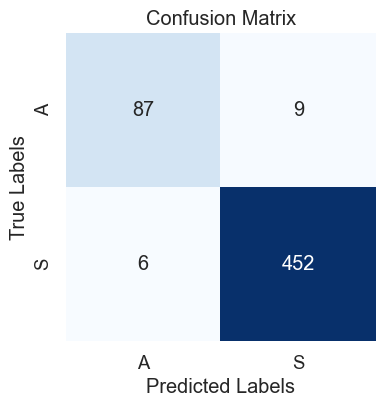

In [ ]:
conf_matrix = confusion_matrix(test['frame_material'],
                               test['prediction_frame_material'])

plt.figure(figsize=(4, 4))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["A", "S"],
            yticklabels=["A", "S"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Model_tam5 LightGBM

In [ ]:
for col in categorical:
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')
    val[col] = val[col].astype('category')

val[categorical].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 330 entries, 777 to 89
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   floor          330 non-null    category
 1   door_leaf      330 non-null    category
 2   r_l_opening    330 non-null    category
 3   host_material  330 non-null    category
 4   from_room      330 non-null    category
 5   to_room        330 non-null    category
dtypes: category(6)
memory usage: 10.7 KB


In [ ]:
params_tam5 = {'verbose':-1,
               'random_state':42,
               'categorical_feature': categorical,
               'learning_rate':0.05,
               'n_estimators': 100
              }

In [ ]:
model_tam5 = LGBMClassifier(**params_tam5)

In [ ]:
model_tam5.fit(train[X],train[y].values.ravel() ,eval_set=[(val[X],val[y].values.ravel())])

Exception in thread Thread-6:
Traceback (most recent call last):
  File "C:\Users\Olga.Poletkina\AppData\Local\anaconda3\envs\ds_practicum_env\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "C:\Users\Olga.Poletkina\AppData\Local\anaconda3\envs\ds_practicum_env\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\Olga.Poletkina\AppData\Local\anaconda3\envs\ds_practicum_env\lib\threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Olga.Poletkina\AppData\Local\anaconda3\envs\ds_practicum_env\lib\subprocess.py", line 1495, in _readerthread
    buffer.append(fh.read())
  File "C:\Users\Olga.Poletkina\AppData\Local\anaconda3\envs\ds_practicum_env\lib\encodings\cp1252.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
UnicodeDecodeError: 'charmap' codec can't decode byte 0x81 in position 3: character maps to <undefined>
  Fi

LGBMClassifier(categorical_feature=['floor', 'door_leaf', 'r_l_opening',
                                    'host_material', 'from_room', 'to_room'],
               learning_rate=0.05, random_state=42, verbose=-1)

In [ ]:
'''lgb.plot_importance(model, importance_type=”split”, figsize=(7, 6), title=”LightGBM Feature Importance (Split)”)
creates a feature importance plot based on the ‘split’ metric. This metric measures how often a feature is used to
split the data in decision trees during training, which helps assess the feature’s importance in making decisions.'''

feature_importances = model_tam5.feature_importances_
feature_names = model_tam5.feature_name_
df_feature_importances = pd.DataFrame({
    'Feature Name': feature_names,
    'Importance (Split)': feature_importances
})
df_feature_importances = df_feature_importances.sort_values(by='Importance (Split)', ascending=False).reset_index(drop=True)

total_importance = df_feature_importances['Importance (Split)'].sum()
df_feature_importances['Importance (%)'] = (df_feature_importances['Importance (Split)'] / total_importance) * 100

df_feature_importances

,Feature Name,Importance (Split),Importance (%)
0,width,2681,22.459579
1,from_room_area,2382,19.954763
2,to_room_area,2176,18.229036
3,height,2076,17.391304
4,host_width,1968,16.486554
5,r_l_opening,511,4.280808
6,to_room,67,0.561280
7,from_room,59,0.494262
8,floor,13,0.108905
9,door_leaf,4,0.033509


### Prediction

In [ ]:
test['prediction_frame_material_lgbm'] = model_tam5.predict(test[X]).ravel()

In [ ]:
test[['frame_material', 'prediction_frame_material', 'prediction_frame_material_lgbm', 'project']]

,frame_material,prediction_frame_material,prediction_frame_material_lgbm,project
1093,S,S,S,tam5
1094,S,S,S,tam5
1095,S,S,S,tam5
1096,S,S,S,tam5
1097,S,S,S,tam5
...,...,...,...,...
1642,S,S,S,tam5
1643,S,S,S,tam5
1644,S,S,S,tam5
1645,S,S,S,tam5


In [ ]:
test['prediction_frame_material_lgbm'].value_counts()

S    464
A     89
H      1
Name: prediction_frame_material_lgbm, dtype: int64

### Number of mismatches

In [ ]:
mismatch_count_tam5 = (test['prediction_frame_material_lgbm'] != test['frame_material']).sum()
score_tam5 = round(mismatch_count_tam5/len(test)*100, 2)
print(f'{100 - round(mismatch_count_tam5/len(test)*100, 2)}% of predictions are correct, \
while using train data = {len(train)}')

95.85% of predictions are correct, while using train data = 1319


### F1 score

In [ ]:
f1_score(test['frame_material'], test['prediction_frame_material_lgbm'], average='micro')

0.9584837545126353

### Confusion matrix

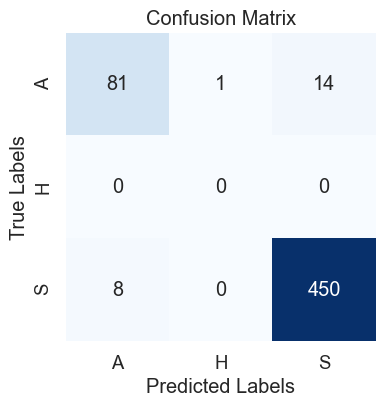

In [ ]:
conf_matrix = confusion_matrix(test['frame_material'],
                               test['prediction_frame_material_lgbm'])

plt.figure(figsize=(4, 4))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["A", "H", "S"],
            yticklabels=["A", "H", "S"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Model_tam5 RandomForestClassifier

### OneHotEncoder

In [ ]:
ohe_features = office_train[X].select_dtypes(include='object').columns.to_list()
print(ohe_features)
# encoder_ohe = OneHotEncoder(drop='first', handle_unknown='error', sparse=False)
# encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
encoder_ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

column_transformer = ColumnTransformer(
    transformers=[('encoder', encoder_ohe, ohe_features)],
    remainder='passthrough'
)

column_transformer.fit(office_train[X])
X_office_train_ohe = column_transformer.transform(office_train[X])
X_test_ohe = column_transformer.transform(test[X])

# pd.DataFrame(X_office_train_ohe)

['floor', 'door_leaf', 'r_l_opening', 'host_material', 'from_room', 'to_room']


### Model

In [ ]:
params_tam5 = {'n_estimators': 150,
               'min_samples_split': 10,
               'max_features': 'log2',
               'max_depth': 15,
               'random_state': 42}

In [ ]:
model_tam5 = RandomForestClassifier(**params_tam5)

In [ ]:
model_tam5.fit(X_office_train_ohe, office_train[y].values.ravel())

RandomForestClassifier(max_depth=15, max_features='log2', min_samples_split=10,
                       n_estimators=150, random_state=42)

### Prediction

In [ ]:
test['prediction_frame_material_rfc'] = model_tam5.predict(X_test_ohe).ravel()

In [ ]:
# test

In [ ]:
test[['frame_material', 'prediction_frame_material', 'prediction_frame_material_lgbm','prediction_frame_material_rfc', 'project']]

,frame_material,prediction_frame_material,prediction_frame_material_lgbm,prediction_frame_material_rfc,project
1093,S,S,S,S,tam5
1094,S,S,S,S,tam5
1095,S,S,S,S,tam5
1096,S,S,S,S,tam5
1097,S,S,S,S,tam5
...,...,...,...,...,...
1642,S,S,S,S,tam5
1643,S,S,S,S,tam5
1644,S,S,S,S,tam5
1645,S,S,S,S,tam5


In [ ]:
test['prediction_frame_material_rfc'].value_counts()

S    527
A     27
Name: prediction_frame_material_rfc, dtype: int64

### Number of mismatches

In [ ]:
mismatch_count_tam5 = (test['prediction_frame_material_rfc'] != test['frame_material']).sum()
score_tam5 = round(mismatch_count_tam5/len(test)*100, 2)
print(f'{100 - round(mismatch_count_tam5/len(test)*100, 2)}% of predictions are correct, \
while using train data = {len(train)}')

86.82% of predictions are correct, while using train data = 1319


### F1 score

In [ ]:
f1_score(test['frame_material'], test['prediction_frame_material_rfc'], average='micro')

0.868231046931408

### Confusion matrix

[[ 25  71]
 [  2 456]]


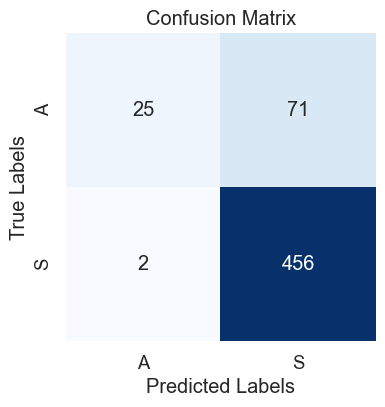

In [ ]:
conf_matrix = confusion_matrix(test['frame_material'],
                               test['prediction_frame_material_rfc'])
print(conf_matrix)
plt.figure(figsize=(4, 4))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["A", "S"],
            yticklabels=["A", "S"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Compare 3 results

In [ ]:
test[['frame_material', 'prediction_frame_material', 'prediction_frame_material_lgbm','prediction_frame_material_rfc', 'project']]

,frame_material,prediction_frame_material,prediction_frame_material_lgbm,prediction_frame_material_rfc,project
1093,S,S,S,S,tam5
1094,S,S,S,S,tam5
1095,S,S,S,S,tam5
1096,S,S,S,S,tam5
1097,S,S,S,S,tam5
...,...,...,...,...,...
1642,S,S,S,S,tam5
1643,S,S,S,S,tam5
1644,S,S,S,S,tam5
1645,S,S,S,S,tam5


In [ ]:
test[
    (test['prediction_frame_material'] == test['prediction_frame_material_lgbm']) &
    (test['prediction_frame_material'] == test['prediction_frame_material_rfc'])
    ]

,Unnamed: 0,floor,door_type,door_number,door_leaf,width,height,r_l_opening,is_escape,host_width,...,to_room,from_room_area,to_room_area,frame_type,frame_material,frame_finish,project,prediction_frame_material,prediction_frame_material_lgbm,prediction_frame_material_rfc
1093,1547,2_UG,unknown,80-437.1,1FL,1.010,2.135,L,unknown,0.250,...,Lager,10.28,10.88,UZ,S,unknown,tam5,S,S,S
1094,1554,2_UG,unknown,80-461.1,2FL,2.010,2.010,R,unknown,0.125,...,Lager,41.31,90.00,UZ,S,unknown,tam5,S,S,S
1095,1555,2_UG,unknown,80-510.1,1FL,1.135,2.135,R,unknown,0.250,...,TRH,9.48,26.19,UZ,S,unknown,tam5,S,S,S
1096,1556,2_UG,unknown,80-511.1,1FL,1.135,2.135,L,unknown,0.250,...,Schleuse,1731.49,9.48,EZ,S,unknown,tam5,S,S,S
1097,1557,2_UG,unknown,80-520.1,1FL,1.135,2.135,R,unknown,0.250,...,TRH,11.07,33.02,UZ,S,unknown,tam5,S,S,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1642,2126,AT,unknown,150-903.2,1FL,1.020,2.090,R,unknown,0.050,...,Technik,0.00,172.02,EZ,S,unknown,tam5,S,S,S
1643,2127,AT,unknown,150-904.1,1FL,1.020,2.090,R,unknown,0.050,...,Technik,0.00,387.91,EZ,S,unknown,tam5,S,S,S
1644,2128,AT,unknown,150-904.3,1FL,1.020,2.090,R,unknown,0.050,...,Technik,0.00,387.91,EZ,S,unknown,tam5,S,S,S
1645,2129,AT,unknown,150-905.1,1FL,1.020,2.090,L,unknown,0.050,...,Technik,0.00,239.73,EZ,S,unknown,tam5,S,S,S


In [ ]:
pd.set_option('display.max_rows', None)

In [ ]:
test[
    (test['prediction_frame_material'] == test['prediction_frame_material_lgbm']) &
    (test['prediction_frame_material'] == test['prediction_frame_material_rfc']) &
    (test['frame_material'] != test['prediction_frame_material_rfc'])
    ]

,Unnamed: 0,floor,door_type,door_number,door_leaf,width,height,r_l_opening,is_escape,host_width,...,to_room,from_room_area,to_room_area,frame_type,frame_material,frame_finish,project,prediction_frame_material,prediction_frame_material_lgbm,prediction_frame_material_rfc
1294,1778,EG,unknown,101-500.2,1FL,1.760,2.76,L,unknown,0.155,...,Foyer,126.66,161.33,-,A,unknown,tam5,S,S,S
1295,1779,EG,unknown,101-500.3,1FL,1.760,2.76,R,unknown,0.155,...,Foyer,0.00,161.33,-,A,unknown,tam5,S,S,S
1356,1840,1_OG,unknown,110-523.1,1FL,1.385,2.26,L,unknown,0.176,...,Büro,27.79,73.80,-,A,unknown,tam5,S,S,S
1502,1986,3_OG,unknown,130-522.1,1FL,1.385,2.26,L,unknown,0.176,...,Büro,27.72,31.86,-,A,unknown,tam5,S,S,S


# Results

In [ ]:
uncorrect_prediction_by_3_models = ((test['prediction_frame_material'] != test['frame_material']) &
                            (test['prediction_frame_material_lgbm'] != test['frame_material']) &
                            (test['prediction_frame_material_rfc'] != test['frame_material'])).sum()

print(f'uncorrect predictions by 3 models = {uncorrect_prediction_by_3_models}')

mismatch_by_three_models = ((test['prediction_frame_material'] != test['frame_material']) |
                            (test['prediction_frame_material_lgbm'] != test['frame_material']) |
                            (test['prediction_frame_material_rfc'] != test['frame_material'])).sum()

print(f'total mismatches by 3 models = {mismatch_by_three_models}')

score_tam5_by_three_models = round(mismatch_by_three_models / len(test) * 100, 2)
print(f'{100 - score_tam5_by_three_models}% of predictions are correct, \
from total test data of size {len(test)}')
print(f'train data = {len(office_train)}, where train = {len(train)}, val = {len(val)}')

uncorrect predictions by 3 models = 4
total mismatches by 3 models = 86
84.48% of predictions are correct, from total test data of size 554
train data = 1649, where train = 1319, val = 330
